Setup of Document

In [1]:
# Recommend running "sbatch /scratch/bclab/lloydt/LT2_UBR-CBR/scripts/jupyterFromCluster.sh" to setup Python environment and Jupyter server.
# Active learning conda environment must be enabled.

import os
import sys
import re

sys.path.insert(0,'/scratch/bclab/lloydt/LT0_ActiveLearning/CRX-Active-Learning')
sys.path.insert(0,'/scratch/bclab/lloydt/LT0_ActiveLearning/CRX-Active-Learning/src')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import logomaker
import src.mpra_tools.modeling as modeling
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from itertools import combinations

from src.mpra_tools import deeplift_utils, loaders, predicted_occupancy, plot_utils, fimo_utils, fasta_utils
from src.selene_files.enhancer_resnet_regression import EnhancerResnet

plot_utils.set_manuscript_params()

/ref/bclab/software/lloydt/.conda/active-learning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set working directories
main_dir = "/scratch/bclab/lloydt/LT2_UBR-CBR"

data_dir = os.path.join(main_dir,"data")
analysis_dir = os.path.join(main_dir,"analysis")

In [3]:
# Helper functions 
# Move to own file at some point

# Annotates the graph with PCC
def annotate_pcc(x, y, **kwargs):
    # Filter out NaN values from x and y
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.text(.1, .9, f'PCC = {r:.2f}', transform=ax.transAxes)

def annotate_rmse(x, y, **kwargs):
    rmse = np.sqrt(np.mean((x - y) ** 2))
    ax = plt.gca()
    ax.text(.1, .8, f'RMSE = {rmse:.2f}', transform=ax.transAxes)

# Define a function to compute the 25th percentile
def quantile25(x):
    return x.quantile(0.25)

# Define a function to compute the 75th percentile
def quantile75(x):
    return x.quantile(0.75)

In [4]:
## Load CNN model
input_sequence_length = 164
model = loaders.load_cnn(
    os.path.join("/scratch/bclab/lloydt/LT0_ActiveLearning/CRX-Active-Learning/RegressionModel/", "best_model.pth.tar"),
    model=EnhancerResnet(input_sequence_length),
    eval_mode=True,
)

/ref/bclab/software/lloydt/.conda/active-learning/lib/python3.9/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loading tables and making necessary modifications.

In [5]:
# Naming table file locations
activity_summary_stats_metadata_loc = os.path.join(data_dir, "activity_summary_stats_and_metadata.txt")

# Loading table file locations
activity_summary_stats_metadata_tbl = pd.read_csv(activity_summary_stats_metadata_loc, sep="\t")

# Subset for mutagenesis test set
main_mutagenesis_tbl = activity_summary_stats_metadata_tbl[activity_summary_stats_metadata_tbl["test_set"] == True]

# Making immediate_precursor2 column where it's immediate precursor unless null then it's label
main_mutagenesis_tbl["immediate_precursor2"] = main_mutagenesis_tbl["immediate_precursor"].fillna(main_mutagenesis_tbl["label"])

/tmp/ipykernel_1182521/3685427871.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_mutagenesis_tbl["immediate_precursor2"] = main_mutagenesis_tbl["immediate_precursor"].fillna(main_mutagenesis_tbl["label"])


In [6]:
### Predicting mutagenesis sequence activity with CNN Model.

# import modeling from the subdirectory src
import src.mpra_tools.modeling
import src.mpra_tools.fasta_utils

# Create a new column on CBRUBR_CRE that is a constant 0 for dummy activity.
main_mutagenesis_tbl["Dummy Activity"] = 0

# Base name for saved files.
base_name="Mutagenesis"

# Save the sequences to a mat file for selene
# Not sure what the third argument "activity_key" is supposed to be.
src.mpra_tools.modeling.prepare_data_for_selene(main_mutagenesis_tbl["sequence"], # Column of 164bp CRE sequences.
                                                main_mutagenesis_tbl["Dummy Activity"], # Dummy activity column
                                                "expression_log2", # Not trying to assume anything about the activity of the sequences.
                                                 os.path.join(analysis_dir, base_name + ".mat")
                                                )

# Write out the CRE IDs (index column) of Mutagenesis sequences to csv file
main_mutagenesis_tbl['label'].to_csv(os.path.join(analysis_dir,base_name + "_ids.txt"), header=["label"], index=False)

# Calculate the predictions for the Mutagenesis sequences using the following scripts: 
# See LT2_MainScripts.txt for setup.
# evaluation function. /scratch/bclab/lloydt/LT2_UBR-CBR/scripts/dropout_eval_regression_on_Mutagenesis.py

/tmp/ipykernel_1182521/3547317141.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_mutagenesis_tbl["Dummy Activity"] = 0


In [7]:
### Adding predicted activity to main_mutagenesis_tbl
# Getting the predicted activity of sequences and merging with main_mutagenesis_tbl
predicted_activity_location = os.path.join(analysis_dir, "Mutagenesis_stdPreds.txt")
predicted_activity_tbl = pd.read_csv(predicted_activity_location, sep="\t")

# Change column name from "standard predicted" to "CNN Predicted Activity"
predicted_activity_tbl = predicted_activity_tbl.rename(columns={"standard predicted": "CNN Predicted Activity"})

# Join the predicted_activity_tbl to the main_mutagenesis_tbl usings keys "seq_id" and "label"
main_mutagenesis_tbl = main_mutagenesis_tbl.merge(predicted_activity_tbl[["seq_id","CNN Predicted Activity"]], how="left", left_on="label", right_on="seq_id", suffixes=("","_y"))

### Create a column that contains the modifications to mutagenize the sequence from the precursor strand.
# Function to extract the list of items from label after the ";" and split by ",".
def extract_items(label):
    def gen_tuple(input):
        return tuple([input.split('d')[0],input.split('d')[1].split('-')[0], input.split('-')[1]])
    parts = label.split(';')
    if len(parts) > 1:
        # From inside to outside, split by HAND_, then split by ',' then tuplize for (location, motif, direction)
        return  list(map(gen_tuple, parts[1].split('HAND_')[1].split(',') ))
    else:
        return []

main_mutagenesis_tbl["Modifications"] = main_mutagenesis_tbl['label'].apply(extract_items)

# Calculate number of Modifications made.
main_mutagenesis_tbl["Number of Modifications"] = main_mutagenesis_tbl["Modifications"].apply(len)


# Subset the main_mutagenesis_tbl for only the precursor strands. Uses the fact that precursors are null in column "immediate_precursor".
precursor_tbl = main_mutagenesis_tbl[main_mutagenesis_tbl["immediate_precursor"].isnull()]


In [8]:
# Troubleshooting section
#main_mutagenesis_tbl_2.columns
#main_mutagenesis_tbl_2[["label","immediate_precursor"]].head()
#main_mutagenesis_tbl_2[main_mutagenesis_tbl["immediate_precursor"].isnull()]


P_occ Motif Discovery and Deeplifting

In [9]:
### Use P_occ to scan for motifs
# Predict motif occupied sites in immediate precursors.
# Cross (merge) all of these locations with all mutagenesis sequences.
# Calculate the deeplift scores at each of these locations. 

predictedOccupancy_location = os.path.join(analysis_dir,"Mutagenesis_predicted-occupancy.tsv")
deeplift_motif_output_location = os.path.join(analysis_dir,"deeplift_motif_scores.tsv")

# PWM location
elife_tf_pwm_loc = os.path.join(data_dir,"pwm/photoreceptor.meme")
# Load PWM to EWM
elife_tf_ewm = predicted_occupancy.read_pwm_to_ewm(elife_tf_pwm_loc)

# Motif dictionary
motif_translate = {'CRX_Corbo' : "CRX",
                    'GFI1_MOUSE.H11MO.0.C' : 'GFI1', 
                    'MAZ_MOUSE.H11MO.1.A' : 'MAZ',
                    'NDF1_MOUSE.H11MO.0.A' : 'NDF1',
                    'NRL_HUMAN.MA0842.1' : 'NRL',
                    'RAX_HUMAN.MA0718.1' : 'RAX',
                    'RORB_HUMAN.MA1150.1' : 'RORB',
                    'MEF2D_MOUSE.H11MO.0.A' : 'MEF2D'}
# Strand direction translation.
direction_translate = {'+' : 'F',
                        '-' : 'R'}

# Convert the keys in elife_tf_ewm using the dictionary motif_translate
elife_tf_ewm_simple = {motif_translate[k]:v for k,v in elife_tf_ewm.items()}

# get_occupied_sites_and_tfs and covert to list of tuples like in previous format
def parse_occ_dictionary(key, value):
    parts = value.split('_')
    return (key, motif_translate["_".join(parts[:-1])], parts[-1][-1])

# Get the predicted motif occupancies and convert from dictionary format to list of tuples.
def p_occ_fromSeq_to_ListofTuples(seq):
    motif_dict = predicted_occupancy.get_occupied_sites_and_tfs(predicted_occupancy.total_landscape(seq,elife_tf_ewm,9))
    return [parse_occ_dictionary(key, value) for key, value in motif_dict.items()]

# Calculate free energy of the matched sequence ahd ignore NaN matched sequences.
def matched_free_energy( matched_seq, ewm ):
    # if a NaN, return NaN
    if matched_seq != matched_seq:
        return np.nan
    elif len(matched_seq[0]) > 1:
        return np.nan
    else:
        return np.min(predicted_occupancy.energy_landscape(matched_seq, ewm))

# Deeplift's importance scoring is computationally intensive so only run if needed.
# Check if p_occ_output_location exists.
if  True:#not (os.path.exists(deeplift_motif_output_location)):
    # Find motifs in every sequence. 
    main_mutagenesis_tbl["p_occ motifs"] = main_mutagenesis_tbl["sequence"].apply(lambda seq: p_occ_fromSeq_to_ListofTuples(seq))

    # Count number of motifs in every sequence.
    main_mutagenesis_tbl["p_occ number of motifs"] = main_mutagenesis_tbl["p_occ motifs"].apply(len)

    # Subset for precursor sequences
    precursor_motifs_tbl = main_mutagenesis_tbl[main_mutagenesis_tbl["immediate_precursor"].isnull()].explode("p_occ motifs")[["label","immediate_precursor","p_occ motifs","sequence"]].rename(columns={"p_occ motifs": "p_occ motif info"})
    # Break out the column "p_occ motifs" tuples
    precursor_motifs_tbl["p_occ start"] = precursor_motifs_tbl["p_occ motif info"].apply(lambda x: x[0])
    precursor_motifs_tbl["p_occ motif"] = precursor_motifs_tbl["p_occ motif info"].apply(lambda x: x[1])
    precursor_motifs_tbl["p_occ strand"] = precursor_motifs_tbl["p_occ motif info"].apply(lambda x: x[2])    
    # Get the end "p_occ end" coordinate by adding the length of the motif to the start coordinate.
    precursor_motifs_tbl["p_occ end"] = precursor_motifs_tbl["p_occ start"] + precursor_motifs_tbl["p_occ motif"].apply(lambda motif: max(elife_tf_ewm_simple[motif]))
    # Get the sequence of the motif by slicing the sequence using the start and end coordinates.
    precursor_motifs_tbl["p_occ matched sequence"] = precursor_motifs_tbl.apply(lambda x: x["sequence"][x["p_occ start"]:x["p_occ end"]+1], axis=1)
    # Get the free energy for every matched sequence.
    precursor_motifs_tbl["p_occ matched sequence free energy"] = precursor_motifs_tbl.apply(lambda row: matched_free_energy(row['p_occ matched sequence'], elife_tf_ewm_simple[row['p_occ motif']]), axis=1)

    # Save precursor_motifs_tbl to file
    precursor_motifs_tbl.to_csv(predictedOccupancy_location, sep="\t", index=False)

    # Merge the precursor_fimo_output table with main_mutagenesis_tbl on column "immediate_precursor"
    deeplift_motif_scores_tbl = precursor_motifs_tbl.rename(columns={"label":"immediate_precursor2","sequence":"precursor sequence"}).merge(main_mutagenesis_tbl[["label","immediate_precursor2","sequence"]],
                                                            how="left",
                                                            left_on="immediate_precursor2",
                                                            right_on='immediate_precursor2', 
                                                            suffixes=("","_y"))

    # Calculate deeplift score for every location where a motif occurs in its precursor sequence. 
    deeplift_motif_scores_tbl["deeplift_score"] = deeplift_motif_scores_tbl.apply(lambda x:deeplift_utils.motif_score(x["sequence"], model, int(x["p_occ start"]), int(x["p_occ end"]+1)), axis=1)

    #Write deeplift_motif_scores_tbl to file
    deeplift_motif_scores_tbl.to_csv(deeplift_motif_output_location, sep="\t", index=False)

    # Read in deeplift_motif_scores_tbl
    deeplift_motif_scores_tbl = pd.read_csv(deeplift_motif_output_location, sep="\t")

    #deeplift_motif_scores_tbl.head()

In [10]:
### Connect up parental strands with daughter strands that have n+1 mutant motif.

# List all n-1 length combinations of a list of tuples. 
def motif_combinations( list_motifs ):
    if len(list_motifs) > 0:
        return list(combinations(list_motifs, len(list_motifs)-1))
    else:
        return []
    
# Create a column that contains all the possible parental strands defined by the modifications.
main_mutagenesis_tbl["All Daughter Modifications"] = main_mutagenesis_tbl["p_occ motifs"].apply(motif_combinations)
# Convert from list of tuples to list of lists
main_mutagenesis_tbl["All Daughter Modifications"] = main_mutagenesis_tbl["All Daughter Modifications"].apply(lambda x: list(map(list, x)))
# Matched with "All Daughter Modifications", create a column that defines the mutations from the parental strand to the daughter strand.
main_mutagenesis_tbl["Modification from All Daughters"] = main_mutagenesis_tbl.apply(lambda row: list(map(lambda parental_modification: set(row["p_occ motifs"]).difference(parental_modification).pop(), row["All Daughter Modifications"])),axis=1)
# Explode the "All Parental Modifications" and "Modification from All Parentals" columns to create a row for each possible parental strand.
permuted_main_mutagenesis_tbl = main_mutagenesis_tbl.explode(["All Daughter Modifications","Modification from All Daughters"])
# Renaming the recently added column from All to "" since each row is for each parental strand.
permuted_main_mutagenesis_tbl.rename(columns={"All Daughter Modifications": "Daughter Motifs",
                                        "Modification from All Daughters": "Daughter Mutant Motif"}, inplace=True)
# Drop ["p_occ number of motifs"]==0, since there can be no daughters strands to connect to.
permuted_main_mutagenesis_tbl = permuted_main_mutagenesis_tbl[permuted_main_mutagenesis_tbl["p_occ number of motifs"]!=0]

## Making some modifications to main_mutagenesis_tbl to create parental_tbl before connecting up with the daughter_mutagenesis_tbl
# Make a copy and fill in null "immediate_precursor" with "label"
daughter_mutagenesis_tbl = main_mutagenesis_tbl.copy()

# Subsetting columns of interest.
daughter_mutagenesis_tbl = daughter_mutagenesis_tbl[["label", "immediate_precursor","immediate_precursor2","sequence", "expression_log2","CNN Predicted Activity","p_occ motifs","p_occ number of motifs"]]

# Rename columns with information specific to parental table. 
daughter_mutagenesis_tbl = daughter_mutagenesis_tbl.rename(columns={"label": "daughter label",
                                                                    "sequence": "daughter sequence",
                                                                    "p_occ motifs": "daughter p_occ motifs",
                                                                    "expression_log2": "daughter expression_log2",
                                                                    "CNN Predicted Activity": "daughter CNN Predicted Activity",
                                                                    "p_occ number of motifs": "daughter p_occ number of motifs"}) 
# Need to learn to merge with a multilevel index to distinguish these parental columns from daughter columns instead of renaming them.

# Tuplizing the Modifications column to make it hashable for the merge.
permuted_main_mutagenesis_tbl["Daughter Motifs"] = permuted_main_mutagenesis_tbl["Daughter Motifs"].apply(tuple)
daughter_mutagenesis_tbl["daughter p_occ motifs"] = daughter_mutagenesis_tbl["daughter p_occ motifs"].apply(tuple)

# Save permuted_main to file
permuted_main_mutagenesis_tbl.to_csv(os.path.join(analysis_dir,"permuted_main_mutagenesis_before_merge_tbl.txt"), sep="\t", index=False)
daughter_mutagenesis_tbl.to_csv(os.path.join(analysis_dir,"daughter_mutagenesis_tbl.txt"), sep="\t",index=False)

# Connect up the parental sequence information from main_mutageneis_tbl to the daughter_mutagenesis_tbl 
    # It's critical ey that "Parental Modification" connects to "Modifications"
permuted_main_mutagenesis_tbl = permuted_main_mutagenesis_tbl.merge(daughter_mutagenesis_tbl,
                                        how="left",
                                        left_on=["immediate_precursor2","Daughter Motifs"],
                                        right_on=["immediate_precursor2","daughter p_occ motifs"],
                                        suffixes=("","_y"))

## Merging the motif importance score based on the modifying motif.
# Break out the motif modification into 3 columns: location, motif, direction
permuted_main_mutagenesis_tbl["Daughter Mutant Motif Start"] = permuted_main_mutagenesis_tbl["Daughter Mutant Motif"].apply(lambda x: x[0]).astype(float)
permuted_main_mutagenesis_tbl["Daughter Mutant Motif Name"] = permuted_main_mutagenesis_tbl["Daughter Mutant Motif"].apply(lambda x: x[1])
# Hopefully this makes it clear how "Motif" was defined since the name is kind of ambiguous.
    # Mainly for plotting purposes.
permuted_main_mutagenesis_tbl["Motif"] = permuted_main_mutagenesis_tbl["Daughter Mutant Motif Name"]
permuted_main_mutagenesis_tbl["Daughter Mutant Motif Strand"] = permuted_main_mutagenesis_tbl["Daughter Mutant Motif"].apply(lambda x: x[2])

# Merge for daughter motif importance score
permuted_main_mutagenesis_tbl = permuted_main_mutagenesis_tbl.merge(deeplift_motif_scores_tbl.rename(columns={"deeplift_score":"daughter deeplift_score"})[['p_occ start', 'p_occ motif','p_occ strand','p_occ matched sequence','label', "daughter deeplift_score"]],
                                                            how="left", 
                                                            left_on=['Daughter Mutant Motif Start', 'Daughter Mutant Motif Name','Daughter Mutant Motif Strand',"daughter label"],
                                                            right_on=["p_occ start","p_occ motif","p_occ strand","label"],
                                                            suffixes=("","_y"))
# Merge for parental motif importance score
permuted_main_mutagenesis_tbl = permuted_main_mutagenesis_tbl.merge(deeplift_motif_scores_tbl.rename(columns={"deeplift_score":"parental deeplift_score"})[['p_occ start', 'p_occ motif','p_occ strand','p_occ matched sequence','p_occ matched sequence free energy','label', "parental deeplift_score"]],
                                                            how="left",
                                                            left_on=['Daughter Mutant Motif Start', 'Daughter Mutant Motif Name','Daughter Mutant Motif Strand',"label"],
                                                            right_on=["p_occ start","p_occ motif","p_occ strand","label"],
                                                            suffixes=("","_y"))

# Dropping extra columns
permuted_main_mutagenesis_tbl = permuted_main_mutagenesis_tbl.drop(columns=['label_y','p_occ start_y', 'p_occ motif_y','p_occ strand_y', 'p_occ matched sequence_y'])

# Saving missing data just in case. 
    # Missing defined as not having parental or daughter motif importance score.
missing_permuted_main_mutagenesis_tbl = permuted_main_mutagenesis_tbl[permuted_main_mutagenesis_tbl["parental deeplift_score"].isnull() | permuted_main_mutagenesis_tbl["daughter deeplift_score"].isnull()]
# Dropping missing data from permuted_main_mutagenesis_tbl
permuted_main_mutagenesis_tbl = permuted_main_mutagenesis_tbl.dropna(subset=["parental deeplift_score","daughter deeplift_score"])

# Create a column that calculates the difference in deeplift score between the daughter and parental strand.
permuted_main_mutagenesis_tbl["daughter-parental deeplift_score"] = permuted_main_mutagenesis_tbl["daughter deeplift_score"] - permuted_main_mutagenesis_tbl["parental deeplift_score"]
# Create a column that calculates the log2 Observed Activity of Mutants over wildtype
permuted_main_mutagenesis_tbl["log2(Observed Activity Mut/WT)"] = permuted_main_mutagenesis_tbl["daughter expression_log2"] - permuted_main_mutagenesis_tbl["expression_log2"] 
# Create a column that calculates the log2 Predicted Activity of Mutants over wildtype
permuted_main_mutagenesis_tbl["log2(Predicted Activity Mut/WT)"] = permuted_main_mutagenesis_tbl["daughter CNN Predicted Activity"] - permuted_main_mutagenesis_tbl["CNN Predicted Activity"]


# Debugging
#print(permuted_main_mutagenesis_tbl.columns)
#display(permuted_main_mutagenesis_tbl.head())


# Save permuted_main_mutagenesis_tbl to file
permuted_main_mutagenesis_tbl.to_csv(os.path.join(analysis_dir,"permuted_main_mutagenesis_tbl.txt"), sep="\t", index=False)


In [11]:
permuted_main_mutagenesis_tbl.columns


Index(['unique_index', 'label', 'expression', 'expression_std',
       'expression_reps', 'mu', 'sigma', 'pval', 'qval', 'expression_log2',
       'library', 'sequence', 'standard_seq', 'scrambled',
       'immediate_precursor', 'original_seq', 'activity_bin',
       'rational_mutagenesis', 'ic_scan', 'original_genomic', 'mut_all_crx',
       'mut_shape', 'entropy_sampling', 'margin_sampling', 'random_sampling',
       'high_conf_pilot', 'high_conf_cnn', 'l9_controls', 'l9_repeat_l8',
       'test_set', 'derived_from_test_set_seq', 'cnn_validation_set',
       'data_batch_name', 'svm_train', 'cnn_train', 'immediate_precursor2',
       'Dummy Activity', 'seq_id', 'CNN Predicted Activity', 'Modifications',
       'Number of Modifications', 'p_occ motifs', 'p_occ number of motifs',
       'Daughter Motifs', 'Daughter Mutant Motif', 'daughter label',
       'immediate_precursor_y', 'daughter sequence',
       'daughter expression_log2', 'daughter CNN Predicted Activity',
       'daughter p

Visualization Setup

In [12]:
# Create a dictionary mapping the unique set of "motif" to the color blind color palette.
motif_color_palette = dict(zip(permuted_main_mutagenesis_tbl["Motif"].unique(), sns.color_palette("colorblind", len(permuted_main_mutagenesis_tbl["Motif"].unique()))))

# Remeber that permuted_mutagenesis_tbl's "Motif" is really defined by "Daughter Mutant Motif Name" . 
# permuted_mutagenesis_tbl is setup to look at what daughters are created from a parental strand "label" and their effects.

Sanity Check Plots

Text(0.5, 1.0, 'Frequency of CREs in Mutagenesis Test Set')

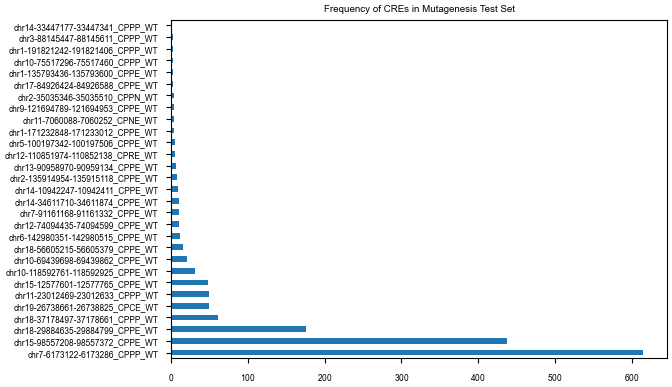

In [13]:
# Plot a bar chart for the frequency of entries in main_mutagenesis_tbl for column "immediate_precursor"
permuted_main_mutagenesis_tbl["immediate_precursor2"].value_counts().plot(kind="barh")
# Give the plot a title
plt.title("Frequency of CREs in Mutagenesis Test Set")

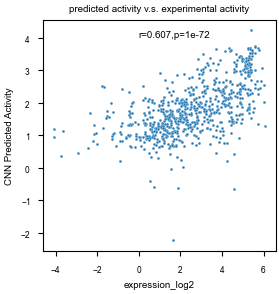

In [14]:
## Check general correlation between predicted activity vs experimental activity:
plt.figure(figsize=(3,3))
x_axis_name = "expression_log2"
y_axis_name = "CNN Predicted Activity"
sns.scatterplot(data=main_mutagenesis_tbl, x=x_axis_name, y=y_axis_name)
plt.title("predicted activity v.s. experimental activity")
r,p = pearsonr(main_mutagenesis_tbl[x_axis_name], main_mutagenesis_tbl[y_axis_name])
plt.text(0,4, 'r={:.3f},p={:.0e}'.format(r,p))
plt.savefig(os.path.join(analysis_dir,"pred_activity_vs_exp_actvity.svg"))

Number of observations: 1609


<Figure size 500x500 with 0 Axes>

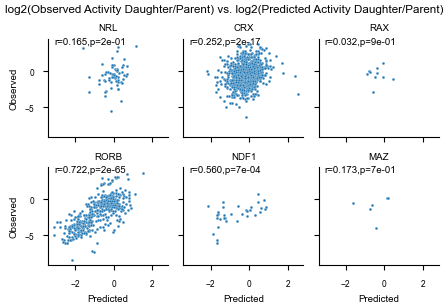

In [15]:
# Check that CNN is predciting the change in activity from the full sequence.
# Correlation between change in observed activity with motif scrambled and the change in predicted score.
plt.figure(figsize=(5,5))
x_axis_name = "log2(Predicted Activity Mut/WT)"
y_axis_name = "log2(Observed Activity Mut/WT)"
x_axis_label = "Predicted"
y_axis_label = "Observed"
plot_title = "log2(Observed Activity Daughter/Parent) vs. log2(Predicted Activity Daughter/Parent)"
plot_save_name = "AllMutants_log2-observed-LFC-activity_vs_log2-predicted-LFC-activity_acrossMotifs.svg"
plot_data = permuted_main_mutagenesis_tbl
g = sns.FacetGrid(plot_data, col="Motif", col_wrap=3, height=1.5)
g.map(sns.scatterplot, x_axis_name, y_axis_name) 
#Couldn't get color coding points to work.  hue="Motif", palette=motif_color_palette)
g.set_titles("{col_name}")
g.fig.suptitle(plot_title, y=1.03)
for ax in g.axes.flat:
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    mask = ~np.isnan(plot_data[x_axis_name]) & ~np.isnan(plot_data[y_axis_name])
    r,p = pearsonr(plot_data[plot_data["Motif"]==ax.title.get_text()][x_axis_name][mask], plot_data[plot_data["Motif"]==ax.title.get_text()][y_axis_name][mask])

    #r,p = pearsonr(plot_data[plot_data[x_axis_name], plot_data[y_axis_name])
    ax.text(0.05,0.95, 'r={:.3f},p={:.0e}'.format(r,p),transform=ax.transAxes)
plt.savefig(os.path.join(analysis_dir,plot_save_name))
print("Number of observations:",len(plot_data))

Number of observations: 1609


<Figure size 500x500 with 0 Axes>

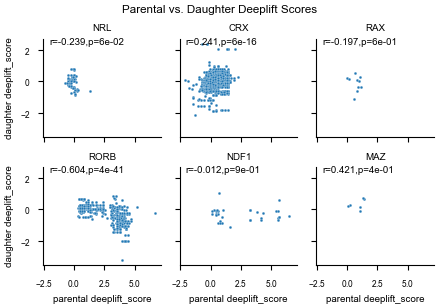

In [16]:
# See the range in deep lift scores for each motif.
# Correlation between change in observed activity with motif scrambled and the change in predicted score.
plt.figure(figsize=(5,5))
x_axis_name = "parental deeplift_score"
y_axis_name = "daughter deeplift_score"
x_axis_label = "parental deeplift_score"
y_axis_label = "daughter deeplift_score"
plot_title = "Parental vs. Daughter Deeplift Scores"
plot_save_name = "AllMutants_parental-vs-daughter-deepliftscores_acrossMotifs.svg"
plot_data = permuted_main_mutagenesis_tbl
g = sns.FacetGrid(plot_data, col="Motif", col_wrap=3, height=1.5)
g.map(sns.scatterplot, x_axis_name, y_axis_name) 
#Couldn't get color coding points to work.  hue="Motif", palette=motif_color_palette)
g.set_titles("{col_name}")
g.fig.suptitle(plot_title, y=1.03)
for ax in g.axes.flat:
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    mask = ~np.isnan(plot_data[x_axis_name]) & ~np.isnan(plot_data[y_axis_name])
    r,p = pearsonr(plot_data[plot_data["Motif"]==ax.title.get_text()][x_axis_name][mask], plot_data[plot_data["Motif"]==ax.title.get_text()][y_axis_name][mask])

    #r,p = pearsonr(plot_data[plot_data[x_axis_name], plot_data[y_axis_name])
    ax.text(0.05,0.95, 'r={:.3f},p={:.0e}'.format(r,p),transform=ax.transAxes)
plt.savefig(os.path.join(analysis_dir,plot_save_name))
print("Number of observations:",len(plot_data))

Visualize Single Motif Mutants

In [18]:
### Compare single mutants change in activity versus intact Motif's importance

# Find single mutants in mutants_tbl
# Subest for mutants_tbl where only one modification is made

Visualize all levels of mutations 

/tmp/ipykernel_1182521/2368037073.py:31: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax2.get_shared_y_axes().join(ax1, ax2)
/tmp/ipykernel_1182521/2368037073.py:32: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax2.get_shared_x_axes().join(ax1, ax2)


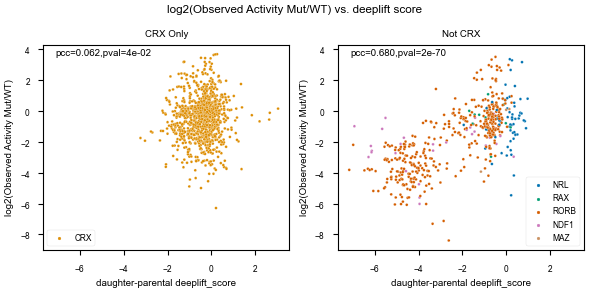

In [20]:
# Comparing CRX versus not CRX motifs

#Plot global settings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
x_axis_name = "daughter-parental deeplift_score"
y_axis_name = "log2(Observed Activity Mut/WT)"
plot_save_name = "AllMutants_log2-observed-LFC-activity_vs_deltadeeplift-score_CRXonlyandnot_motif-colored.svg"
fig.suptitle('log2(Observed Activity Mut/WT) vs. deeplift score')
#sns.set_palette(motif_color_palette)
# Using seaborn, make a scatterplot of "log2(Observed Activity Mut/WT)" vs "deeplift_score" with points colored by "motif"

# Set plot_data equal to single_mutants_tbl where "motif" is CRX
plot_data = permuted_main_mutagenesis_tbl[permuted_main_mutagenesis_tbl["Daughter Mutant Motif Name"] == "CRX"]
sns.scatterplot(data=plot_data, x=x_axis_name, y=y_axis_name, hue="Daughter Mutant Motif Name", palette=motif_color_palette, ax=ax1)
ax1.set_title("CRX Only")
ax1.legend(loc='lower left')
mask = ~np.isnan(plot_data[x_axis_name]) & ~np.isnan(plot_data[y_axis_name])
r,p = pearsonr(plot_data[x_axis_name][mask], plot_data[y_axis_name][mask])
ax1.text(0.05,0.95, 'pcc={:.3f},pval={:.0e}'.format(r,p),transform=ax1.transAxes)

# Set plot_data equal to single_mutants_tbl where "motif" is NOT CRX
plot_data = permuted_main_mutagenesis_tbl[permuted_main_mutagenesis_tbl["Daughter Mutant Motif Name"] != "CRX"]
sns.scatterplot(data=plot_data, x=x_axis_name, y=y_axis_name, hue="Daughter Mutant Motif Name", palette=motif_color_palette, ax=ax2)
ax2.set_title("Not CRX")
ax2.legend(loc='lower right')

mask = ~np.isnan(plot_data[x_axis_name]) & ~np.isnan(plot_data[y_axis_name])
r,p = pearsonr(plot_data[x_axis_name][mask], plot_data[y_axis_name][mask])
ax2.text(0.05,0.95, 'pcc={:.3f},pval={:.0e}'.format(r,p),transform=ax2.transAxes)
# Share axes between subplots
ax2.get_shared_y_axes().join(ax1, ax2)
ax2.get_shared_x_axes().join(ax1, ax2)


plt.tight_layout()
plt.savefig(os.path.join(analysis_dir,plot_save_name))

<Figure size 500x500 with 0 Axes>

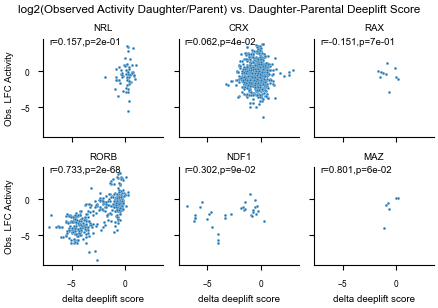

In [22]:
## Correlation between change in observed activity with motif scrambled and the change in deeplift score across motif.
plt.figure(figsize=(5,5))
x_axis_name = "daughter-parental deeplift_score"
x_axis_label = "delta deeplift score"
y_axis_name = "log2(Observed Activity Mut/WT)"
y_axis_label = "Obs. LFC Activity"
plot_title = "log2(Observed Activity Daughter/Parent) vs. Daughter-Parental Deeplift Score"
plot_save_name = "AllMutants_log2-observed-LFC-activity_vs_deltadeeplift_acrossMotifs.svg"
plot_data = permuted_main_mutagenesis_tbl
g = sns.FacetGrid(plot_data, col="Motif", col_wrap=3, height=1.5)
g.map(sns.scatterplot, x_axis_name, y_axis_name) 
#Couldn't get color coding points to work.  hue="Motif", palette=motif_color_palette)
g.fig.suptitle(plot_title, y=1.03) # Overall title.
g.set_titles("{col_name}") # Each plot's title.
for ax in g.axes.flat:
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    mask = ~np.isnan(plot_data[x_axis_name]) & ~np.isnan(plot_data[y_axis_name])
    r,p = pearsonr(plot_data[plot_data["Motif"]==ax.title.get_text()][x_axis_name][mask], plot_data[plot_data["Motif"]==ax.title.get_text()][y_axis_name][mask])

    #r,p = pearsonr(plot_data[plot_data[x_axis_name], plot_data[y_axis_name])
    ax.text(0.05,0.95, 'r={:.3f},p={:.0e}'.format(r,p),transform=ax.transAxes)
plt.savefig(os.path.join(analysis_dir,plot_save_name))

/tmp/ipykernel_1182521/3517222242.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_data = permuted_main_mutagenesis_tbl.groupby("p_occ matched sequence").filter(lambda x: len(x) >= 15)[permuted_main_mutagenesis_tbl["Motif"].isin(["RORB"])]


<Figure size 500x500 with 0 Axes>

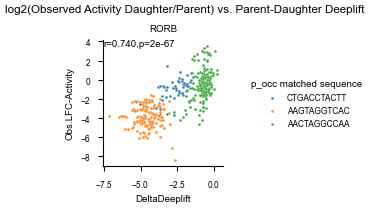

In [23]:
### Troubleshooting: look at matched sequences to see if that's explaining the change in deeplift scores.
# Correlation between change in observed activity with motif scrambled and the change in predicted score.
plt.figure(figsize=(5,5))
x_axis_name = "daughter-parental deeplift_score"
y_axis_name = "log2(Observed Activity Mut/WT)"
x_axis_label = "DeltaDeeplift"
y_axis_label = "Obs.LFC-Activity"
plot_title = "log2(Observed Activity Daughter/Parent) vs. Parent-Daughter Deeplift"
plot_subtitle = "Filtered for >40 examples of each matched sequence."
plot_save_name = "AllMutants_log2-observed-LFC-activity_vs_deltadeeplift_RORB_coloredbyMatchedSequence.svg"
plot_data = permuted_main_mutagenesis_tbl.groupby("p_occ matched sequence").filter(lambda x: len(x) >= 15)[permuted_main_mutagenesis_tbl["Motif"].isin(["RORB"])]
g = sns.FacetGrid(plot_data, col="Motif", hue="p_occ matched sequence", col_wrap=1, height=2)
plt.subplots_adjust(bottom=0.25)
#g = sns.jointplot(data=plot_data, x=x_axis_name, y=y_axis_name, hue="precursor_matched_sequence", col="Motif", kind="scatter", height=3, aspect=1)
g = (g.map(sns.scatterplot, x_axis_name, y_axis_name).add_legend())
g.set_titles("{col_name}")
#g.fig.suptitle(plot_title + "\n" + plot_subtitle, y=1.1)
g.fig.suptitle(plot_title, y=1.05)
#g.fig.text(0.95, 0.05, plot_subtitle, ha='right', va='bottom')
for ax in g.axes.flat:
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    mask = ~np.isnan(plot_data[x_axis_name]) & ~np.isnan(plot_data[y_axis_name])
    r,p = pearsonr(plot_data[plot_data["Motif"]==ax.title.get_text()][x_axis_name][mask], plot_data[plot_data["Motif"]==ax.title.get_text()][y_axis_name][mask])
    ax.text(0.0,0.95, 'r={:.3f},p={:.0e}'.format(r,p),transform=ax.transAxes)
plt.savefig(os.path.join(analysis_dir,plot_save_name))

/tmp/ipykernel_1182521/609138411.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_data = permuted_main_mutagenesis_tbl.groupby("p_occ matched sequence").filter(lambda x: len(x) >= 15)[permuted_main_mutagenesis_tbl["Motif"].isin(["RORB"])]


<Figure size 500x500 with 0 Axes>

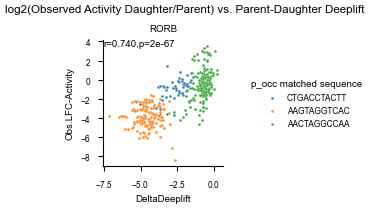

In [24]:
### Troubleshooting: look at matched sequences to see if that's explaining the change in deeplift scores.
# Correlation between change in observed activity with motif scrambled and the change in predicted score.
plt.figure(figsize=(5,5))
x_axis_name = "daughter-parental deeplift_score"
y_axis_name = "log2(Observed Activity Mut/WT)"
x_axis_label = "DeltaDeeplift"
y_axis_label = "Obs.LFC-Activity"
plot_title = "log2(Observed Activity Daughter/Parent) vs. Parent-Daughter Deeplift"
plot_subtitle = "Filtered for >40 examples of each matched sequence."
plot_save_name = "AllMutants_log2-observed-LFC-activity_vs_deltadeeplift_RORB_coloredbyFreeEnergy.svg"
plot_data = permuted_main_mutagenesis_tbl.groupby("p_occ matched sequence").filter(lambda x: len(x) >= 15)[permuted_main_mutagenesis_tbl["Motif"].isin(["RORB"])]
g = sns.FacetGrid(plot_data, col="Motif", hue="p_occ matched sequence", col_wrap=1, height=2)
plt.subplots_adjust(bottom=0.25)
#g = sns.jointplot(data=plot_data, x=x_axis_name, y=y_axis_name, hue="precursor_matched_sequence", col="Motif", kind="scatter", height=3, aspect=1)
g = (g.map(sns.scatterplot, x_axis_name, y_axis_name).add_legend())
g.set_titles("{col_name}")
#g.fig.suptitle(plot_title + "\n" + plot_subtitle, y=1.1)
g.fig.suptitle(plot_title, y=1.05)
#g.fig.text(0.95, 0.05, plot_subtitle, ha='right', va='bottom')
for ax in g.axes.flat:
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    mask = ~np.isnan(plot_data[x_axis_name]) & ~np.isnan(plot_data[y_axis_name])
    r,p = pearsonr(plot_data[plot_data["Motif"]==ax.title.get_text()][x_axis_name][mask], plot_data[plot_data["Motif"]==ax.title.get_text()][y_axis_name][mask])
    ax.text(0.0,0.95, 'r={:.3f},p={:.0e}'.format(r,p),transform=ax.transAxes)
plt.savefig(os.path.join(analysis_dir,plot_save_name))

/tmp/ipykernel_1182521/833470444.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_data = permuted_main_mutagenesis_tbl.groupby("p_occ matched sequence").filter(lambda x: len(x) >= 15)[permuted_main_mutagenesis_tbl["Motif"].isin(["RORB"])]


<Figure size 500x500 with 0 Axes>

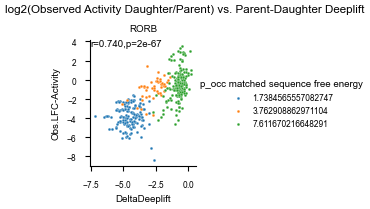

In [25]:
### Troubleshooting: look at matched sequences free energy to see if that's explaining the change in deeplift scores.
# Correlation between change in observed activity with motif scrambled and the change in predicted score.
plt.figure(figsize=(5,5))
x_axis_name = "daughter-parental deeplift_score"
y_axis_name = "log2(Observed Activity Mut/WT)"
x_axis_label = "DeltaDeeplift"
y_axis_label = "Obs.LFC-Activity"
plot_title = "log2(Observed Activity Daughter/Parent) vs. Parent-Daughter Deeplift"
plot_subtitle = "Filtered for >40 examples of each matched sequence."
plot_save_name = "AllMutants_log2-observed-LFC-activity_vs_deltadeeplift_RORB_coloredbyMotifFreeEnergy.svg"
plot_data = permuted_main_mutagenesis_tbl.groupby("p_occ matched sequence").filter(lambda x: len(x) >= 15)[permuted_main_mutagenesis_tbl["Motif"].isin(["RORB"])]
g = sns.FacetGrid(plot_data, col="Motif", hue="p_occ matched sequence free energy", col_wrap=1, height=2)
plt.subplots_adjust(bottom=0.25)
#g = sns.jointplot(data=plot_data, x=x_axis_name, y=y_axis_name, hue="precursor_matched_sequence", col="Motif", kind="scatter", height=3, aspect=1)
g = (g.map(sns.scatterplot, x_axis_name, y_axis_name).add_legend())

g.set_titles("{col_name}")
#g.fig.suptitle(plot_title + "\n" + plot_subtitle, y=1.1)
g.fig.suptitle(plot_title, y=1.05)
#g.fig.text(0.95, 0.05, plot_subtitle, ha='right', va='bottom')
for ax in g.axes.flat:
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    mask = ~np.isnan(plot_data[x_axis_name]) & ~np.isnan(plot_data[y_axis_name])
    r,p = pearsonr(plot_data[plot_data["Motif"]==ax.title.get_text()][x_axis_name][mask], plot_data[plot_data["Motif"]==ax.title.get_text()][y_axis_name][mask])
    ax.text(0.0,0.95, 'r={:.3f},p={:.0e}'.format(r,p),transform=ax.transAxes)
plt.savefig(os.path.join(analysis_dir,plot_save_name))

/tmp/ipykernel_1182521/401729353.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_data = permuted_main_mutagenesis_tbl.groupby("p_occ matched sequence").filter(lambda x: len(x) >= 15)[permuted_main_mutagenesis_tbl["Motif"].isin(["CRX"])]


<Figure size 500x500 with 0 Axes>

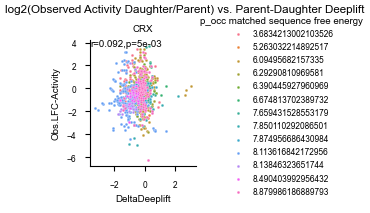

In [26]:
### Troubleshooting: look at matched sequences free energy to see if that's explaining the change in deeplift scores.
# Correlation between change in observed activity with motif scrambled and the change in predicted score.
# https://stackoverflow.com/questions/44641669/scatterplot-with-point-colors-representing-a-continuous-variable-in-seaborn-face
plt.figure(figsize=(5,5))
x_axis_name = "daughter-parental deeplift_score"
y_axis_name = "log2(Observed Activity Mut/WT)"
x_axis_label = "DeltaDeeplift"
y_axis_label = "Obs.LFC-Activity"
plot_title = "log2(Observed Activity Daughter/Parent) vs. Parent-Daughter Deeplift"
plot_subtitle = "Filtered for >40 examples of each matched sequence."
plot_save_name = "AllMutants_log2-observed-LFC-activity_vs_deltadeeplift_CRX_coloredbyMotifFreeEnergy.svg"
plot_data = permuted_main_mutagenesis_tbl.groupby("p_occ matched sequence").filter(lambda x: len(x) >= 15)[permuted_main_mutagenesis_tbl["Motif"].isin(["CRX"])]
g = sns.FacetGrid(plot_data, col="Motif", hue="p_occ matched sequence free energy", col_wrap=1, height=2)
plt.subplots_adjust(bottom=0.25)
#g = sns.jointplot(data=plot_data, x=x_axis_name, y=y_axis_name, hue="precursor_matched_sequence", col="Motif", kind="scatter", height=3, aspect=1)
g = (g.map(sns.scatterplot, x_axis_name, y_axis_name).add_legend())

g.set_titles("{col_name}")
#g.fig.suptitle(plot_title + "\n" + plot_subtitle, y=1.1)
g.fig.suptitle(plot_title, y=1.05)
#g.fig.text(0.95, 0.05, plot_subtitle, ha='right', va='bottom')
for ax in g.axes.flat:
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    mask = ~np.isnan(plot_data[x_axis_name]) & ~np.isnan(plot_data[y_axis_name])
    r,p = pearsonr(plot_data[plot_data["Motif"]==ax.title.get_text()][x_axis_name][mask], plot_data[plot_data["Motif"]==ax.title.get_text()][y_axis_name][mask])
    ax.text(0.0,0.95, 'r={:.3f},p={:.0e}'.format(r,p),transform=ax.transAxes)
plt.savefig(os.path.join(analysis_dir,plot_save_name))

Archived Code